In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from simple_colors import*
from termcolor import colored

import time

import datatable as dt
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
import optuna
import gc
from numba import jit

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import LabelEncoder,Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [22]:
train = pd.read_csv(r"C:\Users\Ong Yi Kai\Desktop\Data\Higgs Boson\training.csv")
submission = pd.read_csv(r"C:\Users\Ong Yi Kai\Desktop\Data\Higgs Boson\test.csv")
print(f'Training shape is {train.shape}\nTesting shape is {test.shape}')

Training shape is (250000, 33)
Testing shape is (550000, 31)


In [25]:
submission_ID, submission_data = submission.iloc[:,0], submission.iloc[:,1:]

# EDA

In [3]:
X, y = train.iloc[:,1:-2], train.iloc[:,-2:]

In [4]:
features = X.columns

remove the last few features for which the variance is extremely low for they do not cahnge values for all target values and hence do not add importance to determining the target`

In [5]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
vt.fit(X)

var = pd.DataFrame(vt.variances_,columns=['Variance'],index=X.columns)
var.sort_values('Variance',ascending=False,inplace=True)

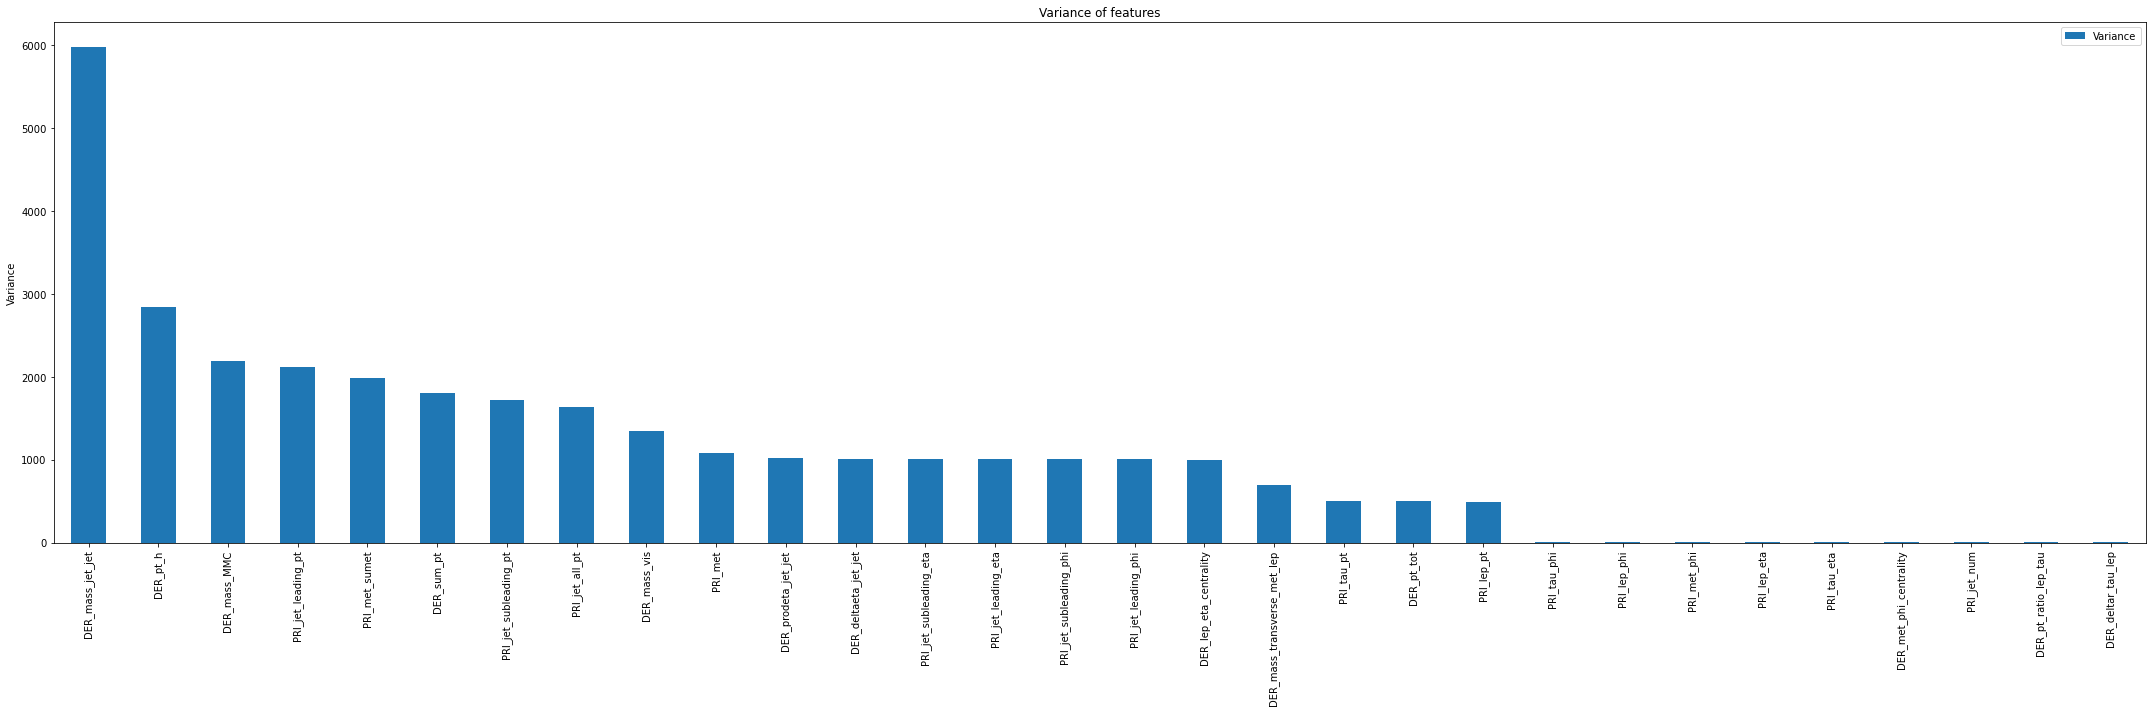

In [6]:
fig, ax = plt.subplots()
var.plot.bar(ax=ax,figsize=(30,10))
ax.set_title('Variance of features')
ax.set_ylabel('Variance')
fig.tight_layout()

In [7]:
vt = VarianceThreshold(threshold=5.0)
print(f'initial shape of X: {X.shape}')
X_trimmed = vt.fit_transform(X)
print(f'final shape of X: {X_trimmed.shape}')
remaining_features_name = var.index[:X_trimmed.shape[1]]
X = pd.DataFrame(X_trimmed,columns=remaining_features_name)

initial shape of X: (250000, 30)
final shape of X: (250000, 21)


In [26]:
#apply variance threshold to subission data
submission_data_trimmed = vt.transform(submission_data)

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X,y.iloc[:,-1])

DecisionTreeClassifier(criterion='entropy')

In [16]:
feature_importance = pd.DataFrame(dtc.feature_importances_,index = X.columns,columns=['importance'])
feature_importance.sort_values('importance',ascending=False,inplace=True)

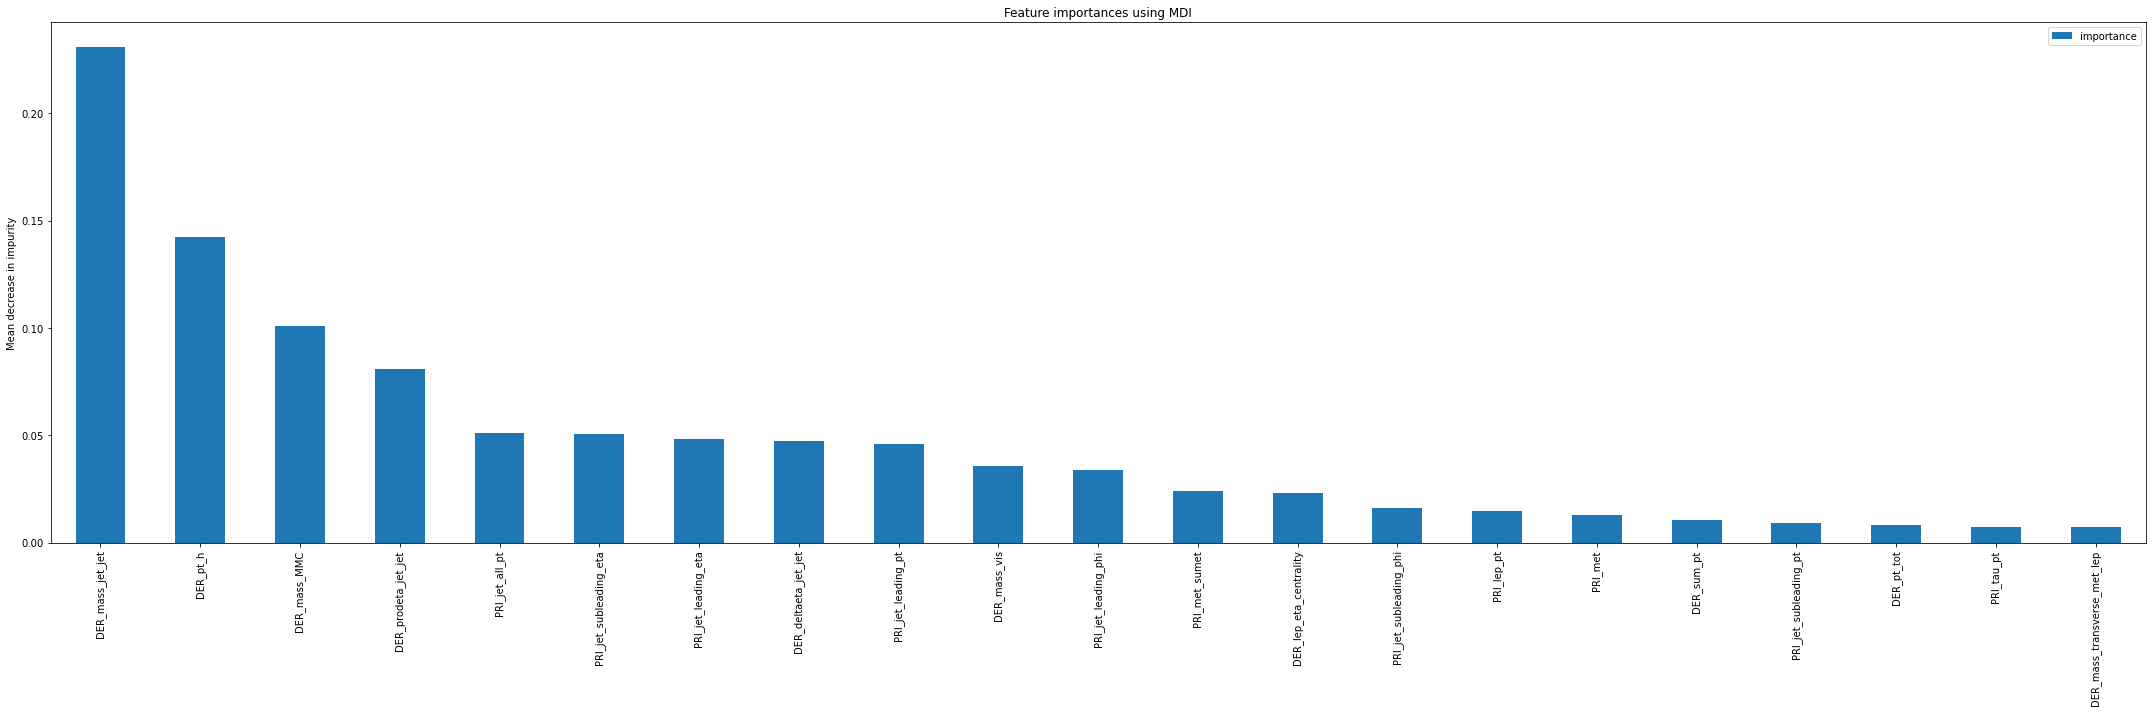

In [17]:
fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax,figsize=(30,10))
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [18]:
def kde_plot(data, features, titleText, hue=None):

    L = len(features)
    nrow = int(np.ceil(L/4))
    ncol = 5
    remove_last = (nrow * ncol) - L

    fig, axs = plt.subplots(nrow, ncol, figsize=(30, 150))
    fig.tight_layout()
    fig.set_facecolor('#e4e4e4')

    while remove_last > 0:
      axs.flat[-remove_last].set_visible(False)
      remove_last -= 1

    fig.subplots_adjust(top = 0.97)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9,  
                    wspace=0.4, 
                    hspace=0.4)
    i = 1
    for feature in features:
        plt.subplot(nrow, ncol, i)
        ax = sns.kdeplot(data[feature], color="m", shade=True, label="%.3f"%(data[feature].skew()))  
        ax = ax.legend(loc = "best")    
        plt.xlabel(feature, fontsize=14, fontweight = 'bold')
        plt.ylabel('Density', fontsize=14, fontweight = 'bold')
        i += 1

    plt.suptitle(titleText, fontsize = 28, fontweight = 'bold', color = 'navy')
    
    plt.show()

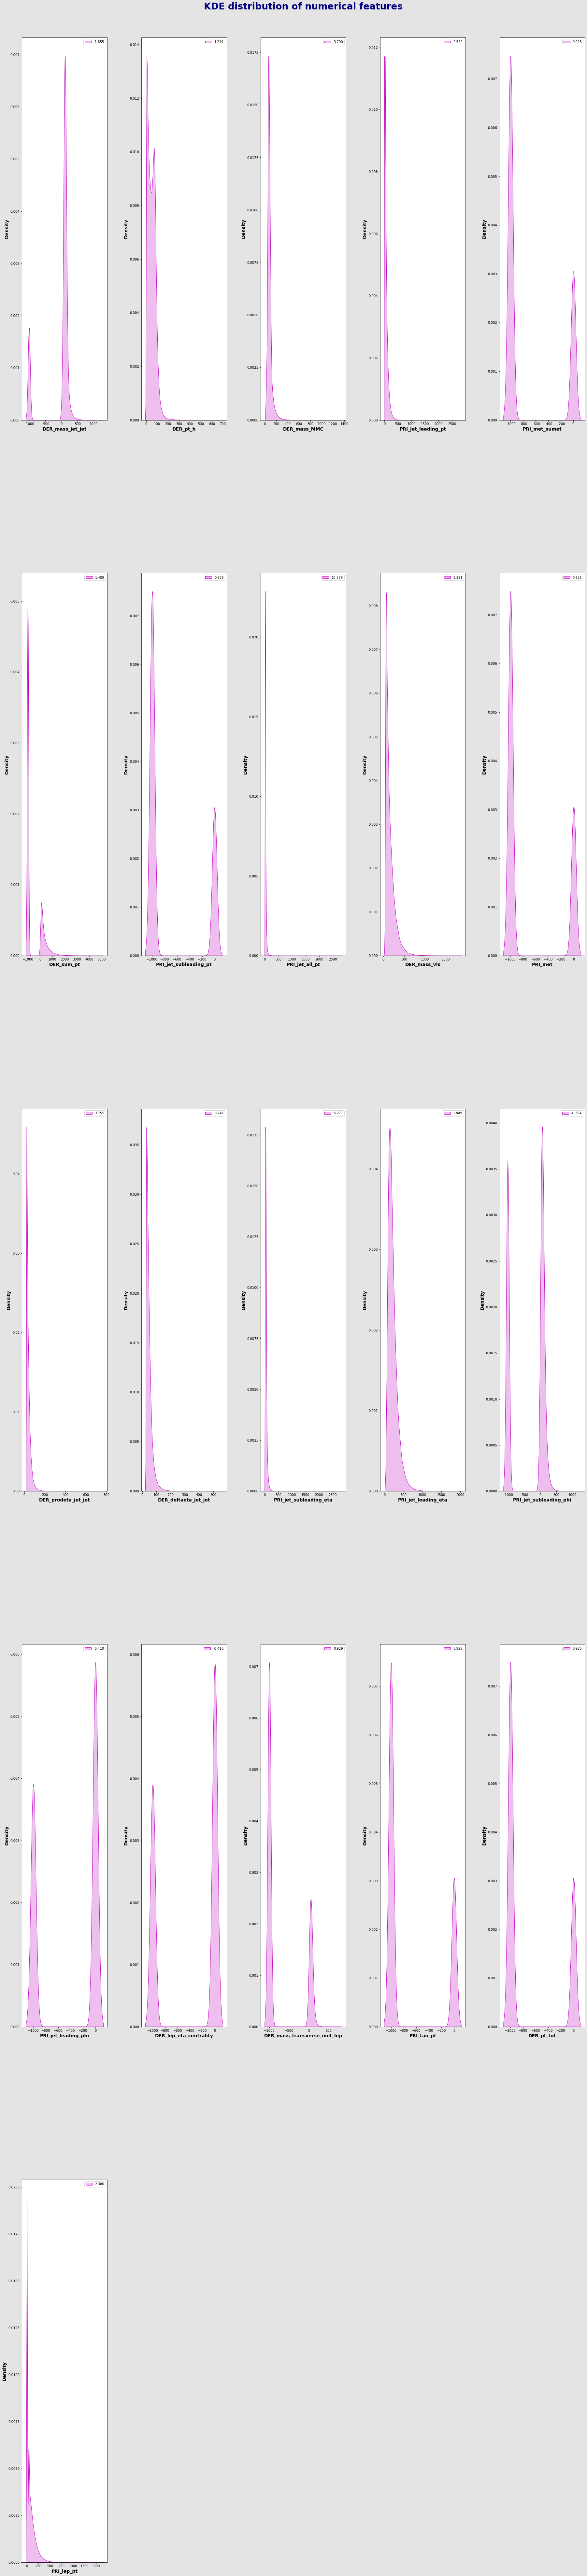

In [45]:
features = [col for col in X.columns]
kde_plot(X, features, 'KDE distribution of numerical features', hue=None)

In [46]:
def box_plot(data, features, titleText, hue=None):

    L = len(features)
    nrow = int(np.ceil(L/4))
    ncol = 5
    remove_last = (nrow * ncol) - L

    fig, axs = plt.subplots(nrow, ncol, figsize=(30,100))
    fig.tight_layout()
    fig.set_facecolor('#e4e4e4')

    while remove_last > 0:
      axs.flat[-remove_last].set_visible(False)
      remove_last = remove_last - 1

    fig.subplots_adjust(top = 0.97)
    plt.subplots_adjust(left=0.1,
                    bottom=0.01, 
                    right=0.9,  
                    wspace=0.4, 
                    hspace=0.4)
    
    i = 1
    for feature in features:
        plt.subplot(nrow, ncol, i)
        v0 = sns.color_palette(palette = "pastel").as_hex()[2]
        ax = sns.boxplot(x = data[feature], color=v0, saturation=.75)   
        plt.xlabel(feature, fontsize=14, fontweight = 'bold')
        plt.ylabel('Values', fontsize=14, fontweight = 'bold')
        i += 1

    plt.suptitle(titleText, fontsize = 28, fontweight = 'bold', color = 'navy')
    plt.show()

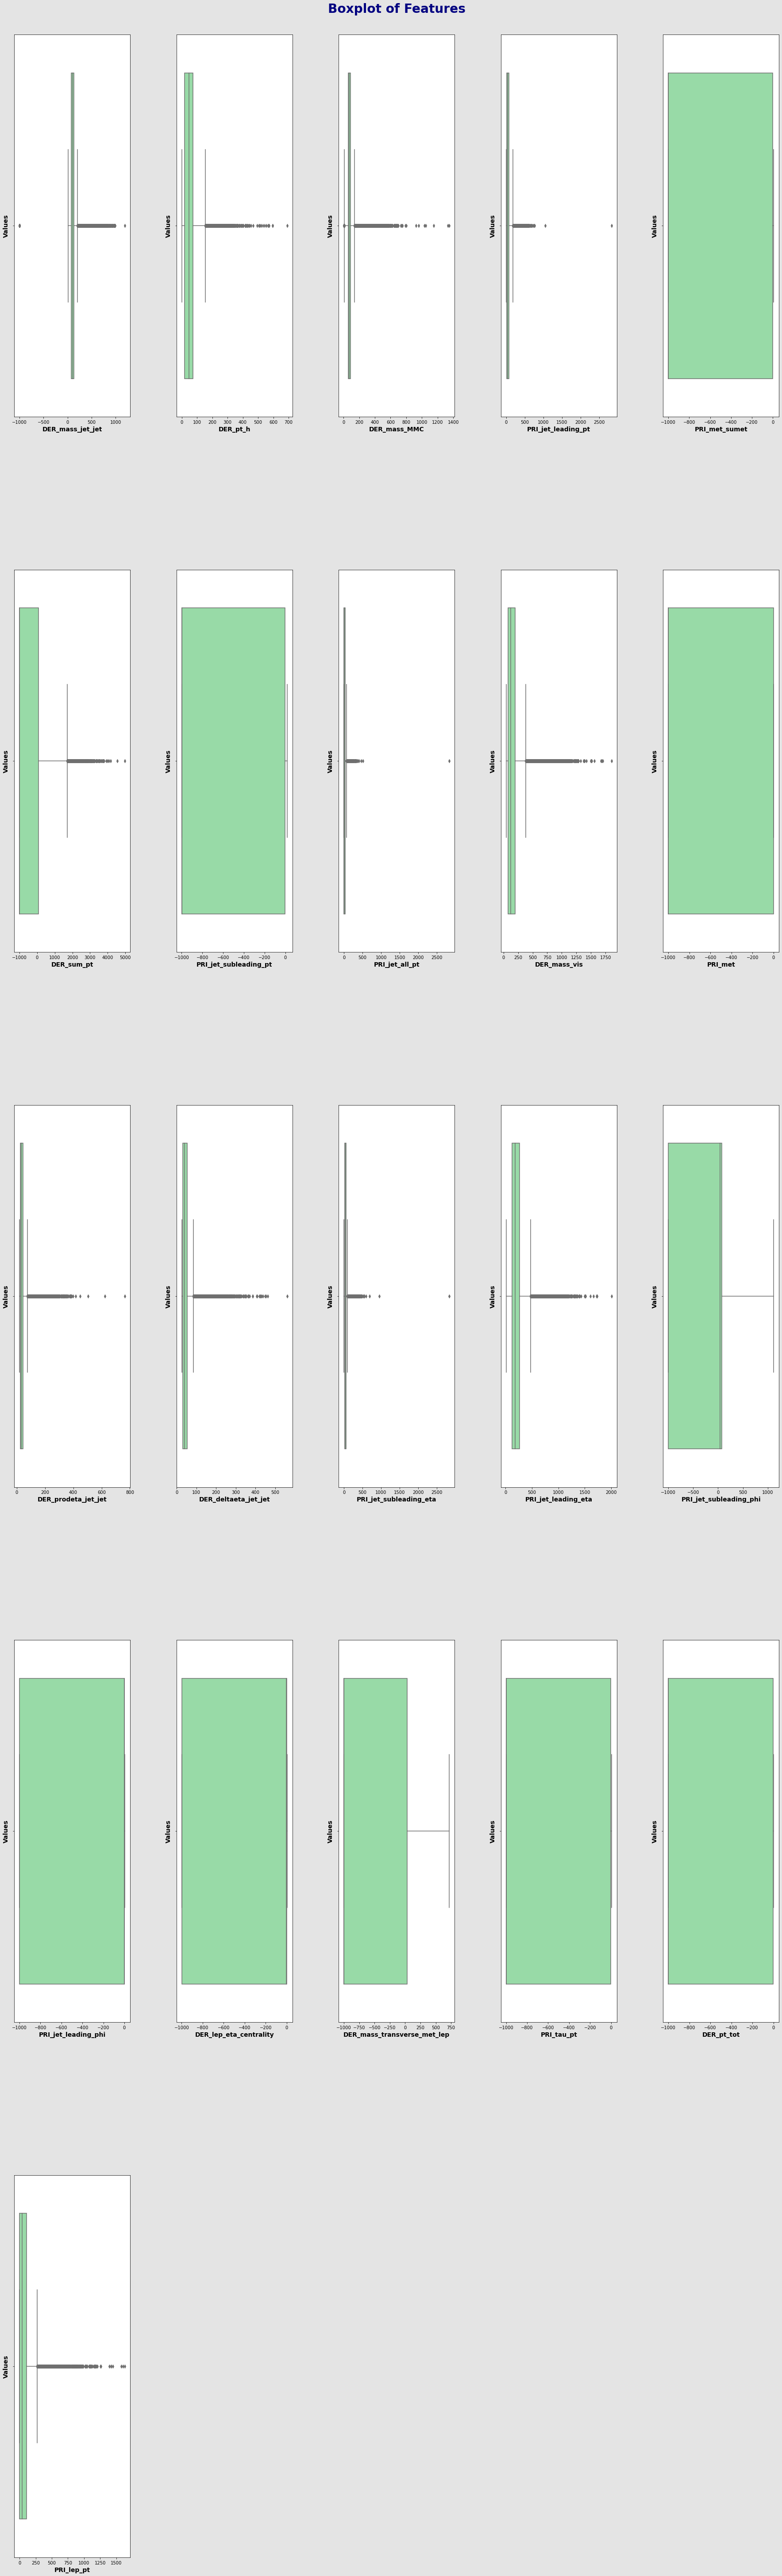

In [47]:
box_plot(X, features, titleText='Boxplot of Features', hue=None)

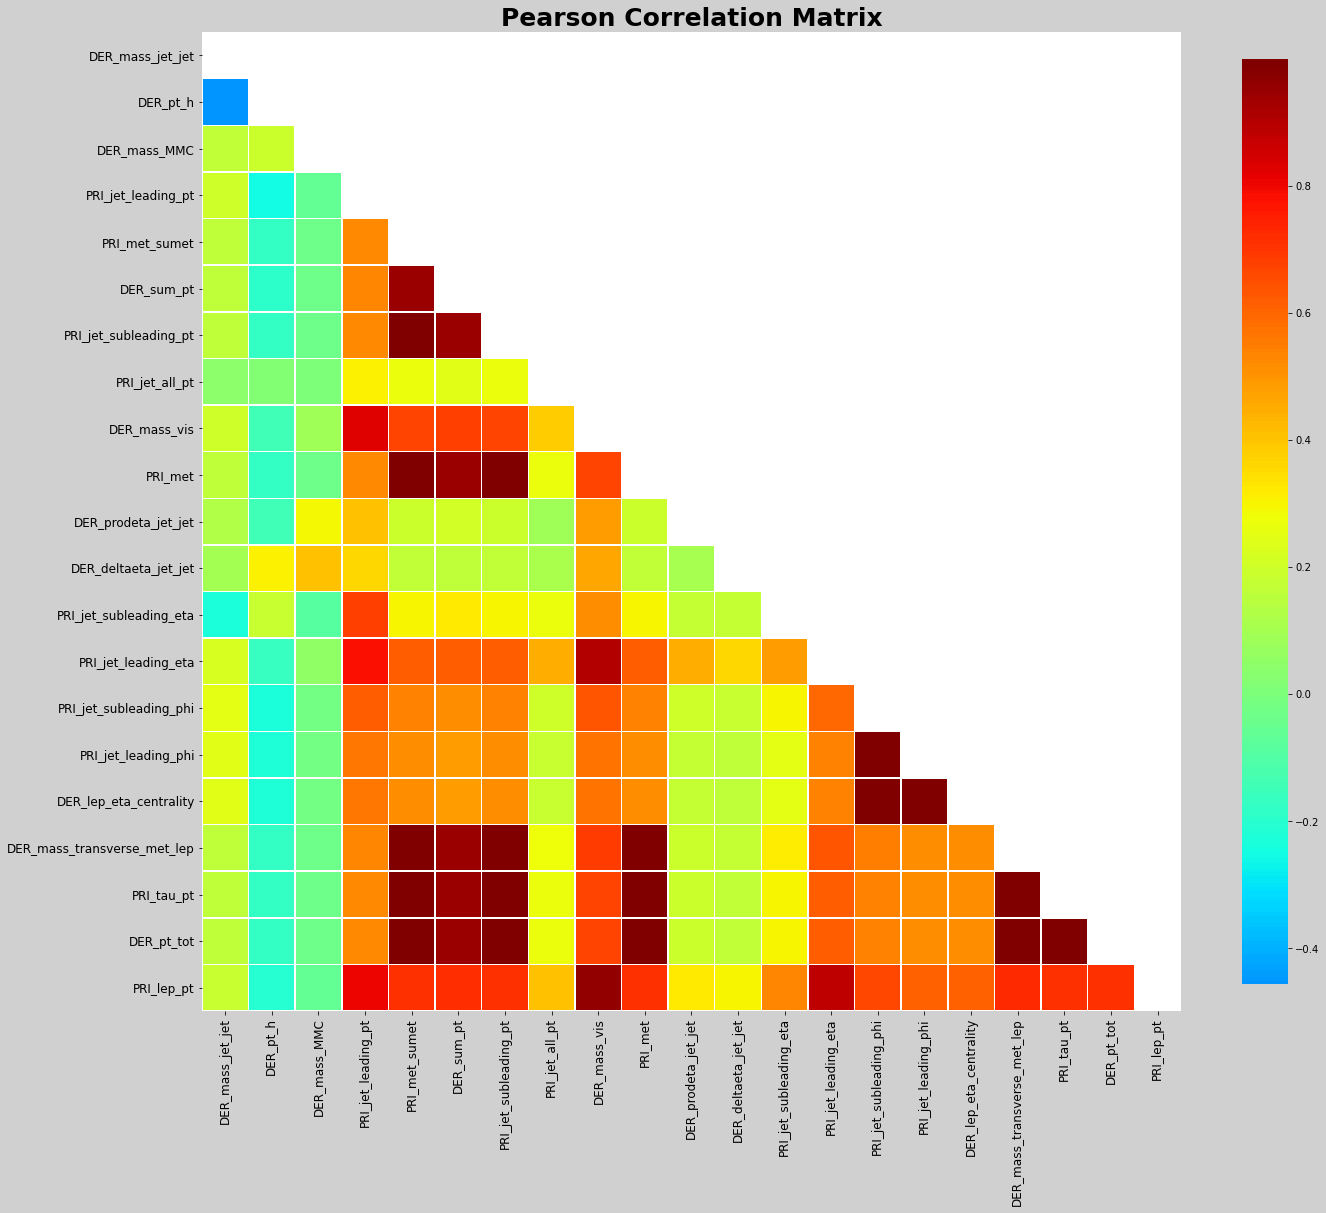

In [48]:
#Correlation plot
correlation = X.corr()

fig,ax = plt.subplots(1,1,figsize=(20,20))
plt.title('Pearson Correlation Matrix', fontweight='bold', fontsize=25)
fig.set_facecolor('#d0d0d0') 

mask = np.triu(np.ones_like(correlation, dtype = bool))
sns.heatmap(correlation,annot = False, center = 0, cmap = 'jet',mask=mask, linewidths = .5, square = True, cbar_kws = {"shrink": .70})
ax.set_xticklabels(ax.get_xticklabels(), fontfamily = 'sans', rotation = 90, fontsize = 12)
ax.set_yticklabels(ax.get_yticklabels(), fontfamily = 'sans', rotation = 0, fontsize = 12)

plt.tight_layout()
plt.show()

# TRAINING

classification training

In [9]:
#encode target data into binary
le = LabelEncoder()
y_target = y.iloc[:,-1:]
le.fit(y_target)
y_binary =np.column_stack((y.iloc[:,0],le.transform(y_target)))

In [10]:
#encode target data into binary
le = LabelEncoder()
y_target = y.iloc[:,-1:]
le.fit(y_target)
y_binary =np.column_stack((y.iloc[:,0],le.transform(y_target)))
X_train, X_test, y_train,y_test = train_test_split(X,y_binary,test_size=0.2,random_state=2021)
print(f'training X:{X_train.shape},y:{y_train.shape}')
print(f'testing X:{X_test.shape},y:{y_test.shape}')

training X:(200000, 21),y:(200000, 2)
testing X:(50000, 21),y:(50000, 2)


In [12]:
lgb_params = {
    'objective': 'binary',
    'verbosity': '-1',
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'early_stopping_round': 100,
    'num_iterations':1000,
    'lambda_l1': 2.2162610843026065,
    'lambda_l2': 5.821787778616915,
    'num_leaves': 33,
    'feature_fraction': 0.12427765225490783,
    'bagging_fraction': 0.2142879960955476,
    'bagging_freq': 2,
    'min_child_samples': 659,
    'n_estimators': 256,
    'max_depth': 5,
    'learning_rate': 0.1869916384264882
  }

In [28]:
#build model
folds = StratifiedKFold(n_splits=10,random_state=2021,shuffle=True)

#create arrays to store and aggregrate predictions after each fold
#aggregating to reduce the varian
lgb_test_pred = np.zeros(len(y_test))
submission_pred = np.zeros(len(submission_data_trimmed))

for fold,(train_idx, val_idx) in enumerate(folds.split(X_train,y_train[:,1])):
    print(f'Fold:{fold}')
    
    X_train_split,y_train_split = X_train.iloc[train_idx,:], y_train[train_idx,1]
    X_cv,y_cv = X_train.iloc[val_idx,:], y_train[val_idx,1]
    
    #Scaling
    scaler = StandardScaler()
    X_train_split = scaler.fit_transform(X_train_split,y_train_split)
    X_cv = scaler.transform(X_cv)
    X_test_scaled = scaler.transform(X_test)
    submission_data_trimmed_scaled = scaler.transform(submission_data_trimmed)
    
    #create Dataset objects
    training = lgb.Dataset(X_train_split, label=y_train_split)
    CV = lgb.Dataset(X_cv, label=y_cv)
    
     #create lgbm model object and train
    model_lgbm = lgb.train(
            lgb_params, 
            training,
            valid_sets=[CV], 
            verbose_eval=100, 
            early_stopping_rounds=100)
   
    #prediction for test and bagging
    test_pred_proba = model_lgbm.predict(X_test_scaled)
    lgb_test_pred += test_pred_proba/folds.n_splits
    
    #prediction for submission data
    submission_pred_proba_fold = model_lgbm.predict(submission_data_trimmed_scaled)
    submission_pred += submission_pred_proba_fold/folds.n_splits
    
    #roc_auc_score using training CV for personal satisfaction XD
    cv_pred = model_lgbm.predict(X_cv)>0.5
    acc = accuracy_score(y_cv,cv_pred)
    print(f"accuracy: {acc:.6f}")


Fold:0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.38323
[200]	valid_0's binary_logloss: 0.378032
[300]	valid_0's binary_logloss: 0.374696
[400]	valid_0's binary_logloss: 0.373098
[500]	valid_0's binary_logloss: 0.372717
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.37249
accuracy: 0.831250
Fold:1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.376307
[200]	valid_0's binary_logloss: 0.37121
[300]	valid_0's binary_logloss: 0.368358
[400]	valid_0's binary_logloss: 0.366675
[500]	valid_0's binary_logloss: 0.365869
[600]	valid_0's binary_logloss: 0.366188
Early stopping, best iteration is:
[557]	valid_0's binary_logloss: 0.36553
accuracy: 0.836800
Fold:2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.382363
[200]	valid_0's binary_logloss: 0.377909
[300]	valid_0's binary_logloss: 0.374665
[400]	valid_0's binary_logloss: 0

In [14]:
#evaluate classifier
accuracy = accuracy_score(y_test,lgb_test_pred>0.5)
print(accuracy)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [44]:
#consolidate predictions for submission
submission_ranks = pd.DataFrame(submission_pred).rank(axis=0, method='average',ascending=True).astype('int64')
submission_pred_df = pd.DataFrame(submission_pred>0.5).replace([0,1],['b','s'])
submission_df = pd.concat([submission_ID,submission_ranks,submission_pred_df],axis=1)
submission_df.to_csv('Higgs_boson_challenge_1st_submission.csv',header=['EventId','RankOrder','Class'],index=None)

Model HyperParameter Tuning

In [172]:
def objective(trial):
    # prameter grid 
    # search about suggest_int, suggest_uniform and all.. it is easy to understand
    param_grid = {        
    'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 20),
    'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 20),
    "num_leaves" : trial.suggest_int("num_leaves", 20, 40),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.0,1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.0,1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 0, 20),
    'min_child_samples': trial.suggest_int('min_child_samples', 200, 750),
    "n_estimators" : trial.suggest_int("n_estimators", 200, 450),
    "max_depth" : trial.suggest_int('max_depth', 3, 8),
    "learning_rate" : trial.suggest_uniform('learning_rate', 0.10, 0.30),
    }
    
    
        
    #build model
    folds = StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)
    acc = np.empty(5)

    for fold,(train_idx, val_idx) in enumerate(folds.split(X_train,y_train[:,1])):
        print(f'Fold:{fold}')

        X_train_split,y_train_split = X_train.iloc[train_idx,:], y_train[train_idx,1]
        X_cv,y_cv = X_train.iloc[val_idx,:], y_train[val_idx,1]

        #Scaling
        scaler = StandardScaler()
        X_train_split = scaler.fit_transform(X_train_split,y_train_split)
        X_cv = scaler.transform(X_cv)

         #create lgbm model object and train
        model = LGBMClassifier(objective="binary", metric='binary_logloss', **param_grid)
        model.fit(X_train_split, np.ravel(y_train_split), eval_set=[(X_cv,np.ravel(y_cv))], early_stopping_rounds=100, eval_metric="accuracy", verbose=False)

        #roc_auc_score using training CV for personal satisfaction XD
        cv_pred = model_lgbm.predict(X_cv)>0.5
        acc[fold] = accuracy_score(y_cv,cv_pred)
        gc.collect()
        
    return np.mean(acc)
    

In [175]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
study.optimize(objective, n_trials=20)

[I 2021-10-12 22:13:22,597] A new study created in memory with name: LGBM Classifier


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.12427765225490783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12427765225490783
[LightGBM] [Warning] lambda_l1 is set=2.2162610843026065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2162610843026065
[LightGBM] [Warning] bagging_fraction is set=0.2142879960955476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2142879960955476
[LightGBM] [Warning] lambda_l2 is set=5.821787778616915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.821787778616915
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.12427765225490783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12427765225490783
[LightGBM] [Warning] lambda_l1 is set=2.2162610843026065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2162610843026065
[LightGBM] [Warning] 

[I 2021-10-12 22:13:39,661] Trial 0 finished with value: 0.84121 and parameters: {'lambda_l1': 2.2162610843026065, 'lambda_l2': 5.821787778616915, 'num_leaves': 33, 'feature_fraction': 0.12427765225490783, 'bagging_fraction': 0.2142879960955476, 'bagging_freq': 2, 'min_child_samples': 659, 'n_estimators': 256, 'max_depth': 5, 'learning_rate': 0.1869916384264882}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.7230623354714009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7230623354714009
[LightGBM] [Warning] lambda_l1 is set=10.785726024037691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.785726024037691
[LightGBM] [Warning] bagging_fraction is set=0.12171707604312865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12171707604312865
[LightGBM] [Warning] lambda_l2 is set=16.565969645294654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.565969645294654
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.7230623354714009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7230623354714009
[LightGBM] [Warning] lambda_l1 is set=10.785726024037691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.785726024037691
[LightGBM] [Warning

[I 2021-10-12 22:13:57,071] Trial 1 finished with value: 0.84121 and parameters: {'lambda_l1': 10.785726024037691, 'lambda_l2': 16.565969645294654, 'num_leaves': 30, 'feature_fraction': 0.7230623354714009, 'bagging_fraction': 0.12171707604312865, 'bagging_freq': 14, 'min_child_samples': 593, 'n_estimators': 271, 'max_depth': 6, 'learning_rate': 0.13622800898545517}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.49865775973292936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49865775973292936
[LightGBM] [Warning] lambda_l1 is set=5.173763864359926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.173763864359926
[LightGBM] [Warning] bagging_fraction is set=0.5316396775809176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5316396775809176
[LightGBM] [Warning] lambda_l2 is set=13.681567568611612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.681567568611612
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.49865775973292936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49865775973292936
[LightGBM] [Warning] lambda_l1 is set=5.173763864359926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.173763864359926
[LightGBM] [Warning] 

[I 2021-10-12 22:14:19,629] Trial 2 finished with value: 0.84121 and parameters: {'lambda_l1': 5.173763864359926, 'lambda_l2': 13.681567568611612, 'num_leaves': 27, 'feature_fraction': 0.49865775973292936, 'bagging_fraction': 0.5316396775809176, 'bagging_freq': 15, 'min_child_samples': 532, 'n_estimators': 393, 'max_depth': 8, 'learning_rate': 0.2889886270422387}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.029478077338970232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.029478077338970232
[LightGBM] [Warning] lambda_l1 is set=7.822474934994991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.822474934994991
[LightGBM] [Warning] bagging_fraction is set=0.4940236683518062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4940236683518062
[LightGBM] [Warning] lambda_l2 is set=19.12881174520931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.12881174520931
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.029478077338970232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.029478077338970232
[LightGBM] [Warning] lambda_l1 is set=7.822474934994991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.822474934994991
[LightGBM] [Warning

[I 2021-10-12 22:14:35,389] Trial 3 finished with value: 0.84121 and parameters: {'lambda_l1': 7.822474934994991, 'lambda_l2': 19.12881174520931, 'num_leaves': 31, 'feature_fraction': 0.029478077338970232, 'bagging_fraction': 0.4940236683518062, 'bagging_freq': 13, 'min_child_samples': 725, 'n_estimators': 332, 'max_depth': 3, 'learning_rate': 0.15454290810686888}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.49029699812110605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49029699812110605
[LightGBM] [Warning] lambda_l1 is set=14.346699409083348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.346699409083348
[LightGBM] [Warning] bagging_fraction is set=0.28623052162519125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28623052162519125
[LightGBM] [Warning] lambda_l2 is set=4.399717250305972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.399717250305972
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.49029699812110605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49029699812110605
[LightGBM] [Warning] lambda_l1 is set=14.346699409083348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.346699409083348
[LightGBM] [Warning

[I 2021-10-12 22:14:52,129] Trial 4 finished with value: 0.84121 and parameters: {'lambda_l1': 14.346699409083348, 'lambda_l2': 4.399717250305972, 'num_leaves': 29, 'feature_fraction': 0.49029699812110605, 'bagging_fraction': 0.28623052162519125, 'bagging_freq': 3, 'min_child_samples': 749, 'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.15254921483285894}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.8502706655376953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8502706655376953
[LightGBM] [Warning] lambda_l1 is set=1.516266001737152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.516266001737152
[LightGBM] [Warning] bagging_fraction is set=0.14850080565044166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14850080565044166
[LightGBM] [Warning] lambda_l2 is set=7.151282857035712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.151282857035712
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.8502706655376953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8502706655376953
[LightGBM] [Warning] lambda_l1 is set=1.516266001737152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.516266001737152
[LightGBM] [Warning] baggin

[I 2021-10-12 22:15:05,208] Trial 5 finished with value: 0.84121 and parameters: {'lambda_l1': 1.516266001737152, 'lambda_l2': 7.151282857035712, 'num_leaves': 26, 'feature_fraction': 0.8502706655376953, 'bagging_fraction': 0.14850080565044166, 'bagging_freq': 6, 'min_child_samples': 215, 'n_estimators': 247, 'max_depth': 3, 'learning_rate': 0.17052099564418072}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.5678591621705379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5678591621705379
[LightGBM] [Warning] lambda_l1 is set=1.9375242946725835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9375242946725835
[LightGBM] [Warning] bagging_fraction is set=0.31190205354563416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31190205354563416
[LightGBM] [Warning] lambda_l2 is set=4.517672367587993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.517672367587993
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.5678591621705379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5678591621705379
[LightGBM] [Warning] lambda_l1 is set=1.9375242946725835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9375242946725835
[LightGBM] [Warning] ba

[I 2021-10-12 22:15:29,293] Trial 6 finished with value: 0.84121 and parameters: {'lambda_l1': 1.9375242946725835, 'lambda_l2': 4.517672367587993, 'num_leaves': 36, 'feature_fraction': 0.5678591621705379, 'bagging_fraction': 0.31190205354563416, 'bagging_freq': 5, 'min_child_samples': 677, 'n_estimators': 318, 'max_depth': 8, 'learning_rate': 0.11536841509947227}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.26890499485003105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26890499485003105
[LightGBM] [Warning] lambda_l1 is set=5.763389742321325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.763389742321325
[LightGBM] [Warning] bagging_fraction is set=0.03282466735323075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.03282466735323075
[LightGBM] [Warning] lambda_l2 is set=4.964802299332753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.964802299332753
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.26890499485003105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26890499485003105
[LightGBM] [Warning] lambda_l1 is set=5.763389742321325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.763389742321325
[LightGBM] [Warning] ba

[I 2021-10-12 22:15:48,053] Trial 7 finished with value: 0.84121 and parameters: {'lambda_l1': 5.763389742321325, 'lambda_l2': 4.964802299332753, 'num_leaves': 40, 'feature_fraction': 0.26890499485003105, 'bagging_fraction': 0.03282466735323075, 'bagging_freq': 5, 'min_child_samples': 446, 'n_estimators': 406, 'max_depth': 5, 'learning_rate': 0.11976309782623258}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.7090887623507315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090887623507315
[LightGBM] [Warning] lambda_l1 is set=17.357936490858815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17.357936490858815
[LightGBM] [Warning] bagging_fraction is set=0.321758911673385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.321758911673385
[LightGBM] [Warning] lambda_l2 is set=7.121730741826051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.121730741826051
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.7090887623507315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090887623507315
[LightGBM] [Warning] lambda_l1 is set=17.357936490858815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17.357936490858815
[LightGBM] [Warning] baggin

[I 2021-10-12 22:16:08,541] Trial 8 finished with value: 0.84121 and parameters: {'lambda_l1': 17.357936490858815, 'lambda_l2': 7.121730741826051, 'num_leaves': 37, 'feature_fraction': 0.7090887623507315, 'bagging_fraction': 0.321758911673385, 'bagging_freq': 5, 'min_child_samples': 374, 'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.22708451990928957}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.49822654031271496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49822654031271496
[LightGBM] [Warning] lambda_l1 is set=2.1293252476523583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1293252476523583
[LightGBM] [Warning] bagging_fraction is set=0.5736277975597993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5736277975597993
[LightGBM] [Warning] lambda_l2 is set=4.296227037599625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.296227037599625
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.49822654031271496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49822654031271496
[LightGBM] [Warning] lambda_l1 is set=2.1293252476523583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1293252476523583
[LightGBM] [Warning

[I 2021-10-12 22:16:25,969] Trial 9 finished with value: 0.84121 and parameters: {'lambda_l1': 2.1293252476523583, 'lambda_l2': 4.296227037599625, 'num_leaves': 34, 'feature_fraction': 0.49822654031271496, 'bagging_fraction': 0.5736277975597993, 'bagging_freq': 14, 'min_child_samples': 335, 'n_estimators': 273, 'max_depth': 4, 'learning_rate': 0.25196099434173547}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.004478332543939811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.004478332543939811
[LightGBM] [Warning] lambda_l1 is set=12.082290456542138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12.082290456542138
[LightGBM] [Warning] bagging_fraction is set=0.9886840789599578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886840789599578
[LightGBM] [Warning] lambda_l2 is set=0.26932911354501243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26932911354501243
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.004478332543939811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.004478332543939811
[LightGBM] [Warning] lambda_l1 is set=12.082290456542138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12.082290456542138
[LightGBM] [W

[I 2021-10-12 22:16:42,555] Trial 10 finished with value: 0.84121 and parameters: {'lambda_l1': 12.082290456542138, 'lambda_l2': 0.26932911354501243, 'num_leaves': 20, 'feature_fraction': 0.004478332543939811, 'bagging_fraction': 0.9886840789599578, 'bagging_freq': 0, 'min_child_samples': 618, 'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.19379029999964595}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.9982680580059313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9982680580059313
[LightGBM] [Warning] lambda_l1 is set=10.597520496489711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.597520496489711
[LightGBM] [Warning] bagging_fraction is set=0.03206710143400188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.03206710143400188
[LightGBM] [Warning] lambda_l2 is set=13.845140771324553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.845140771324553
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.9982680580059313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9982680580059313
[LightGBM] [Warning] lambda_l1 is set=10.597520496489711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.597520496489711
[LightGBM] [Warning

[I 2021-10-12 22:16:54,914] Trial 11 finished with value: 0.84121 and parameters: {'lambda_l1': 10.597520496489711, 'lambda_l2': 13.845140771324553, 'num_leaves': 32, 'feature_fraction': 0.9982680580059313, 'bagging_fraction': 0.03206710143400188, 'bagging_freq': 20, 'min_child_samples': 591, 'n_estimators': 293, 'max_depth': 6, 'learning_rate': 0.20041519912358643}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.21570915943514635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21570915943514635
[LightGBM] [Warning] lambda_l1 is set=14.321525280661119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.321525280661119
[LightGBM] [Warning] bagging_fraction is set=0.20084403195322714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20084403195322714
[LightGBM] [Warning] lambda_l2 is set=18.702317690501296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.702317690501296
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.21570915943514635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21570915943514635
[LightGBM] [Warning] lambda_l1 is set=14.321525280661119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.321525280661119
[LightGBM] [War

[I 2021-10-12 22:17:12,776] Trial 12 finished with value: 0.84121 and parameters: {'lambda_l1': 14.321525280661119, 'lambda_l2': 18.702317690501296, 'num_leaves': 24, 'feature_fraction': 0.21570915943514635, 'bagging_fraction': 0.20084403195322714, 'bagging_freq': 10, 'min_child_samples': 609, 'n_estimators': 331, 'max_depth': 7, 'learning_rate': 0.10039136111713788}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.28407161062619257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28407161062619257
[LightGBM] [Warning] lambda_l1 is set=8.168695600274384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.168695600274384
[LightGBM] [Warning] bagging_fraction is set=0.40981761491090085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40981761491090085
[LightGBM] [Warning] lambda_l2 is set=12.626444982266175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.626444982266175
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.28407161062619257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28407161062619257
[LightGBM] [Warning] lambda_l1 is set=8.168695600274384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.168695600274384
[LightGBM] [Warning] 

[I 2021-10-12 22:17:26,587] Trial 13 finished with value: 0.84121 and parameters: {'lambda_l1': 8.168695600274384, 'lambda_l2': 12.626444982266175, 'num_leaves': 33, 'feature_fraction': 0.28407161062619257, 'bagging_fraction': 0.40981761491090085, 'bagging_freq': 9, 'min_child_samples': 505, 'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.14511894860118052}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.7023931913400546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7023931913400546
[LightGBM] [Warning] lambda_l1 is set=4.384143706861848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.384143706861848
[LightGBM] [Warning] bagging_fraction is set=0.7626413487482204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7626413487482204
[LightGBM] [Warning] lambda_l2 is set=10.465096509353474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.465096509353474
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.7023931913400546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7023931913400546
[LightGBM] [Warning] lambda_l1 is set=4.384143706861848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.384143706861848
[LightGBM] [Warning] bagg

[I 2021-10-12 22:17:49,387] Trial 14 finished with value: 0.84121 and parameters: {'lambda_l1': 4.384143706861848, 'lambda_l2': 10.465096509353474, 'num_leaves': 30, 'feature_fraction': 0.7023931913400546, 'bagging_fraction': 0.7626413487482204, 'bagging_freq': 18, 'min_child_samples': 650, 'n_estimators': 277, 'max_depth': 6, 'learning_rate': 0.19857883341002275}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.6892208338593618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6892208338593618
[LightGBM] [Warning] lambda_l1 is set=18.923258931305913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18.923258931305913
[LightGBM] [Warning] bagging_fraction is set=0.13085856237407253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13085856237407253
[LightGBM] [Warning] lambda_l2 is set=15.854763501445705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.854763501445705
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.6892208338593618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6892208338593618
[LightGBM] [Warning] lambda_l1 is set=18.923258931305913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18.923258931305913
[LightGBM] [Warning] 

[I 2021-10-12 22:18:13,491] Trial 15 finished with value: 0.84121 and parameters: {'lambda_l1': 18.923258931305913, 'lambda_l2': 15.854763501445705, 'num_leaves': 36, 'feature_fraction': 0.6892208338593618, 'bagging_fraction': 0.13085856237407253, 'bagging_freq': 0, 'min_child_samples': 551, 'n_estimators': 247, 'max_depth': 7, 'learning_rate': 0.23244509016702652}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.36525104192479163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36525104192479163
[LightGBM] [Warning] lambda_l1 is set=13.282986448130146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.282986448130146
[LightGBM] [Warning] bagging_fraction is set=0.007828070734036269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.007828070734036269
[LightGBM] [Warning] lambda_l2 is set=0.2980410109479905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2980410109479905
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.36525104192479163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36525104192479163
[LightGBM] [Warning] lambda_l1 is set=13.282986448130146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.282986448130146
[LightGBM] [W

[I 2021-10-12 22:18:24,977] Trial 16 finished with value: 0.84121 and parameters: {'lambda_l1': 13.282986448130146, 'lambda_l2': 0.2980410109479905, 'num_leaves': 23, 'feature_fraction': 0.36525104192479163, 'bagging_fraction': 0.007828070734036269, 'bagging_freq': 12, 'min_child_samples': 460, 'n_estimators': 363, 'max_depth': 5, 'learning_rate': 0.17448151405125148}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.12161364670587066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12161364670587066
[LightGBM] [Warning] lambda_l1 is set=4.733461421272511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.733461421272511
[LightGBM] [Warning] bagging_fraction is set=0.7423970645918077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7423970645918077
[LightGBM] [Warning] lambda_l2 is set=9.985707192291336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.985707192291336
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.12161364670587066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12161364670587066
[LightGBM] [Warning] lambda_l1 is set=4.733461421272511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.733461421272511
[LightGBM] [Warning] ba

[I 2021-10-12 22:18:41,241] Trial 17 finished with value: 0.84121 and parameters: {'lambda_l1': 4.733461421272511, 'lambda_l2': 9.985707192291336, 'num_leaves': 28, 'feature_fraction': 0.12161364670587066, 'bagging_fraction': 0.7423970645918077, 'bagging_freq': 18, 'min_child_samples': 662, 'n_estimators': 296, 'max_depth': 4, 'learning_rate': 0.19544743555304747}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.38649378368097403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38649378368097403
[LightGBM] [Warning] lambda_l1 is set=16.995548250909845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.995548250909845
[LightGBM] [Warning] bagging_fraction is set=0.22943515780426987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22943515780426987
[LightGBM] [Warning] lambda_l2 is set=16.734372307988934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.734372307988934
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.38649378368097403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38649378368097403
[LightGBM] [Warning] lambda_l1 is set=16.995548250909845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.995548250909845
[LightGBM] [Warni

[I 2021-10-12 22:19:01,148] Trial 18 finished with value: 0.84121 and parameters: {'lambda_l1': 16.995548250909845, 'lambda_l2': 16.734372307988934, 'num_leaves': 40, 'feature_fraction': 0.38649378368097403, 'bagging_fraction': 0.22943515780426987, 'bagging_freq': 0, 'min_child_samples': 547, 'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.24513123023861186}. Best is trial 0 with value: 0.84121.


Fold:0
[LightGBM] [Warning] feature_fraction is set=0.1557111523716392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1557111523716392
[LightGBM] [Warning] lambda_l1 is set=13.573056117732726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.573056117732726
[LightGBM] [Warning] bagging_fraction is set=0.008906726069047294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.008906726069047294
[LightGBM] [Warning] lambda_l2 is set=0.20195882914656327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20195882914656327
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Fold:1
[LightGBM] [Warning] feature_fraction is set=0.1557111523716392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1557111523716392
[LightGBM] [Warning] lambda_l1 is set=13.573056117732726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.573056117732726
[LightGBM] [War

[I 2021-10-12 22:19:14,082] Trial 19 finished with value: 0.84121 and parameters: {'lambda_l1': 13.573056117732726, 'lambda_l2': 0.20195882914656327, 'num_leaves': 21, 'feature_fraction': 0.1557111523716392, 'bagging_fraction': 0.008906726069047294, 'bagging_freq': 10, 'min_child_samples': 438, 'n_estimators': 364, 'max_depth': 5, 'learning_rate': 0.17441344921417146}. Best is trial 0 with value: 0.84121.


In [183]:
study.best_params

{'lambda_l1': 2.2162610843026065,
 'lambda_l2': 5.821787778616915,
 'num_leaves': 33,
 'feature_fraction': 0.12427765225490783,
 'bagging_fraction': 0.2142879960955476,
 'bagging_freq': 2,
 'min_child_samples': 659,
 'n_estimators': 256,
 'max_depth': 5,
 'learning_rate': 0.1869916384264882}